In [5]:
%pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 18.2 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
])

# Download and load training data
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load test data
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Quick look at the data
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Each image is 28x28 grayscale
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")  # [batch_size, 1, 28, 28]
print(f"Labels shape: {labels.shape}")  # [batch_size]

Training samples: 60000
Test samples: 10000
Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


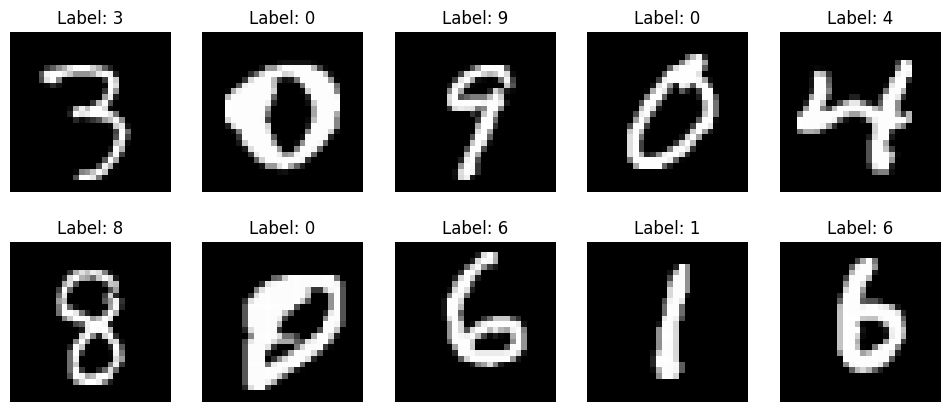

In [2]:
import matplotlib.pyplot as plt

# Get a batch
images, labels = next(iter(train_loader))

# Plot first 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.show()

In [2]:
import torch
import torch.nn as nn

# Generator: takes noise + digit label, outputs 28x28 image
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super(Generator, self).__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()  # Output in [-1, 1]
        )
    
    def forward(self, noise, labels):
        # Concatenate noise and label embedding
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat([noise, label_embedding], dim=1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Discriminator: takes image + digit label, outputs real/fake probability
class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(28*28 + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability
        )
    
    def forward(self, img, labels):
        # Flatten image and concatenate with label embedding
        img_flat = img.view(img.size(0), -1)
        label_embedding = self.label_emb(labels)
        disc_input = torch.cat([img_flat, label_embedding], dim=1)
        validity = self.model(disc_input)
        return validity

# Initialize models
latent_dim = 100
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

print("Generator:", generator)
print("Discriminator:", discriminator)

Generator: Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator: Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): L

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
generator = generator.to(device)
discriminator = discriminator.to(device)

# Load MNIST (normalize to [-1, 1] to match generator's Tanh output)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Rescale from [0,1] to [-1,1]
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 20
latent_dim = 100

for epoch in range(num_epochs):
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Loss on real images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), real_labels)
        
        # Generate fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise, labels)
        
        # Loss on fake images
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach(), labels), fake_labels)
        
        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Generator wants discriminator to think fake images are real
        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(noise, labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, labels), real_labels)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Print progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    # Save sample images every epoch (optional)
    if epoch % 5 == 0:
        with torch.no_grad():
            # Generate one of each digit
            sample_labels = torch.arange(0, 10).to(device)
            sample_noise = torch.randn(10, latent_dim).to(device)
            sample_imgs = generator(sample_noise, sample_labels)
            
            # Save or display (you can add visualization code here)
            print(f"Epoch {epoch}: Generated samples")

print("Training complete!")

# Save models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

[Epoch 0/20] [Batch 0/938] [D loss: 0.7037] [G loss: 0.7336]
[Epoch 0/20] [Batch 100/938] [D loss: 0.6771] [G loss: 0.8853]
[Epoch 0/20] [Batch 200/938] [D loss: 0.6510] [G loss: 0.8135]
[Epoch 0/20] [Batch 300/938] [D loss: 0.6209] [G loss: 0.8462]
[Epoch 0/20] [Batch 400/938] [D loss: 0.6477] [G loss: 0.8850]
[Epoch 0/20] [Batch 500/938] [D loss: 0.6282] [G loss: 0.7964]
[Epoch 0/20] [Batch 600/938] [D loss: 0.6285] [G loss: 1.1527]
[Epoch 0/20] [Batch 700/938] [D loss: 0.5838] [G loss: 0.9851]
[Epoch 0/20] [Batch 800/938] [D loss: 0.6919] [G loss: 0.4767]
[Epoch 0/20] [Batch 900/938] [D loss: 0.6020] [G loss: 0.8027]
Epoch 0: Generated samples
[Epoch 1/20] [Batch 0/938] [D loss: 0.6390] [G loss: 1.4570]
[Epoch 1/20] [Batch 100/938] [D loss: 0.5991] [G loss: 1.0930]
[Epoch 1/20] [Batch 200/938] [D loss: 0.6037] [G loss: 1.2031]
[Epoch 1/20] [Batch 300/938] [D loss: 0.5850] [G loss: 0.9160]
[Epoch 1/20] [Batch 400/938] [D loss: 0.5657] [G loss: 1.1208]
[Epoch 1/20] [Batch 500/938] [D 

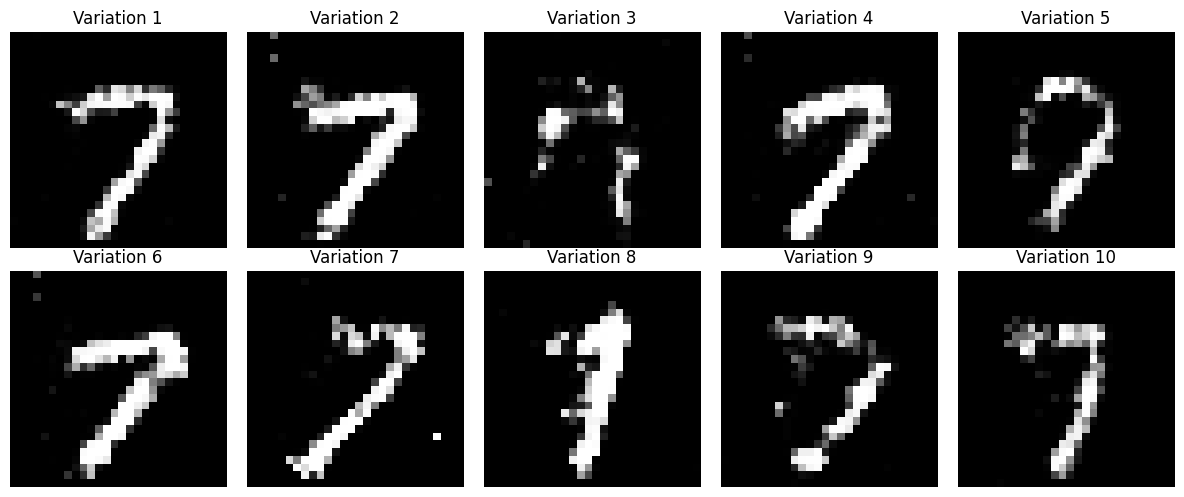

In [7]:
import torch
import matplotlib.pyplot as plt

# Load the trained generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=100)
generator.load_state_dict(torch.load('generator.pth'))
generator.to(device)
generator.eval()  # Set to evaluation mode

# Generate 10 different versions of digit 7
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        digit = torch.tensor([7]).to(device)
        noise = torch.randn(1, 100).to(device)  # Different noise each time
        generated_img = generator(noise, digit)
        
        img = generated_img.cpu().squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Variation {i+1}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Export PyTorch model to ONNX
import torch

generator.eval()
dummy_noise = torch.randn(1, 100)
dummy_label = torch.tensor([5])

torch.onnx.export(
    generator,
    (dummy_noise, dummy_label),
    "generator.onnx",
    input_names=['noise', 'label'],
    output_names=['image'],
    dynamic_axes={'noise': {0: 'batch'}, 'label': {0: 'batch'}}
)

In [ ]:
import pytorch_lightning as pl

class CGAN(pl.LightningModule):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        self.automatic_optimization = False  # Manual for GANs
        
    def training_step(self, batch, batch_idx):
        real_imgs, labels = batch
        
        opt_g, opt_d = self.optimizers()
        
        # Train discriminator
        noise = torch.randn(real_imgs.size(0), self.latent_dim).to(self.device)
        fake_imgs = self.generator(noise, labels)
        
        real_loss = F.binary_cross_entropy(
            self.discriminator(real_imgs, labels),
            torch.ones(real_imgs.size(0), 1).to(self.device)
        )
        fake_loss = F.binary_cross_entropy(
            self.discriminator(fake_imgs.detach(), labels),
            torch.zeros(real_imgs.size(0), 1).to(self.device)
        )
        d_loss = (real_loss + fake_loss) / 2
        
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        
        # Train generator
        noise = torch.randn(real_imgs.size(0), self.latent_dim).to(self.device)
        gen_imgs = self.generator(noise, labels)
        g_loss = F.binary_cross_entropy(
            self.discriminator(gen_imgs, labels),
            torch.ones(real_imgs.size(0), 1).to(self.device)
        )
        
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        
        # Logging happens automatically!
        self.log('g_loss', g_loss, prog_bar=True)
        self.log('d_loss', d_loss, prog_bar=True)
        
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return [opt_g, opt_d]

# Training becomes:
model = CGAN()
trainer = pl.Trainer(max_epochs=50, accelerator='auto')
trainer.fit(model, train_loader)